The aim of this project is to take the data in https://www.kaggle.com/sl6149/data-scientist-job-market-in-the-us?select=fulltimeCHI.csv about data scientist hire in 2018 in the US and "kind-of" replicate the analysis from the uploader published in https://nycdatascience.com/blog/student-works/who-gets-hired-an-outlook-of-the-u-s-data-scientist-job-market-in-2018/

Lert's start by loading the necessary packages for R

In [1]:
library(tidyverse)
library(data.table)
library(tm)
library(slam)
library(stringr)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose

Loading required package: NLP

Attaching package: ‘NLP’

The following object is masked from ‘package:ggplot2’:

    annotate



As second step, let's import the data using fread, and then let's check a bit the structure of the data.

In [2]:
job_descriptions <- fread('alldata.csv')
str(job_descriptions)

Classes ‘data.table’ and 'data.frame':	6964 obs. of  5 variables:
 $ position   : chr  "Development Director" "An Ostentatiously-Excitable Principal Research Assistant to Chief Scientist" "Data Scientist" "Data Analyst" ...
 $ company    : chr  "ALS TDI" "The Hexagon Lavish" "Xpert Staffing" "Operation HOPE" ...
 $ description: chr  "Development Director\nALS Therapy Development Institute has an immediate opening for Development Directors. Rep"| __truncated__ "Job Description\n\n\"\"The road that leads to accomplishment is narrow.\"\" -Desmond\nOstentatious is a strong "| __truncated__ "Growing company located in the Atlanta, GA area is currently looking to add a Data Scientist to their team. The"| __truncated__ "DEPARTMENT: Program OperationsPOSITION LOCATIONS: Atlanta, GA.ACCOUNTABILITY:  President of Program OperationsF"| __truncated__ ...
 $ reviews    : int  NA NA NA 44 550 385 385 899 3343 4494 ...
 $ location   : chr  "Atlanta, GA 30301 " "Atlanta, GA" "Atlanta, GA" "Atlanta, GA

This crude inspection reveals one feature that it's for me easier to manage: <br>
1. the same city appears with different names because postal codes are sometimes included <br>
2. States appear within the location and not as a separate column. <br>

To solve this issue, I first split the string a few times to isolate City and State information, and throw away postal codes.

In [3]:
job_descriptions <- job_descriptions %>%
    separate(location, c('city', 'state'), ', ', fill = "left") %>%
    separate(state, c('state'), ' ', extra = 'drop') #%>%
    #mutate(city = as.factor(city), state = as.factor(state))

str(job_descriptions)
table(job_descriptions$position)

Classes ‘data.table’ and 'data.frame':	6964 obs. of  6 variables:
 $ position   : chr  "Development Director" "An Ostentatiously-Excitable Principal Research Assistant to Chief Scientist" "Data Scientist" "Data Analyst" ...
 $ company    : chr  "ALS TDI" "The Hexagon Lavish" "Xpert Staffing" "Operation HOPE" ...
 $ description: chr  "Development Director\nALS Therapy Development Institute has an immediate opening for Development Directors. Rep"| __truncated__ "Job Description\n\n\"\"The road that leads to accomplishment is narrow.\"\" -Desmond\nOstentatious is a strong "| __truncated__ "Growing company located in the Atlanta, GA area is currently looking to add a Data Scientist to their team. The"| __truncated__ "DEPARTMENT: Program OperationsPOSITION LOCATIONS: Atlanta, GA.ACCOUNTABILITY:  President of Program OperationsF"| __truncated__ ...
 $ reviews    : int  NA NA NA 44 550 385 385 899 3343 4494 ...
 $ city       : chr  "Atlanta" "Atlanta" "Atlanta" "Atlanta" ...
 $ state      : c


                                                                                                                                                                                 
                                                                                                                                                                              11 
                                                                                                                                                       .NET/SharePoint Developer 
                                                                                                                                                                               1 
                                                                                                                                        (Contract) Business Intelligence Analyst 
                                                                                                             

A second feature that is immediately clear from the structure of the dataframe with explicit locations is that the job titles are pretty heterogeneous. To get a better sense of what it's in there, I will attempt use the tm package to count the frequency of ngrams made by 2 words. Such choice is justified because common positions for data-related jobs are combination of two words (e.g. "data science", "data engineer", "data analyst", "machine learning") 

<<TermDocumentMatrix (terms: 44, documents: 6964)>>
Non-/sparse entries: 5470/300946
Sparsity           : 98%
Maximal term length: 24
Weighting          : term frequency (tf)

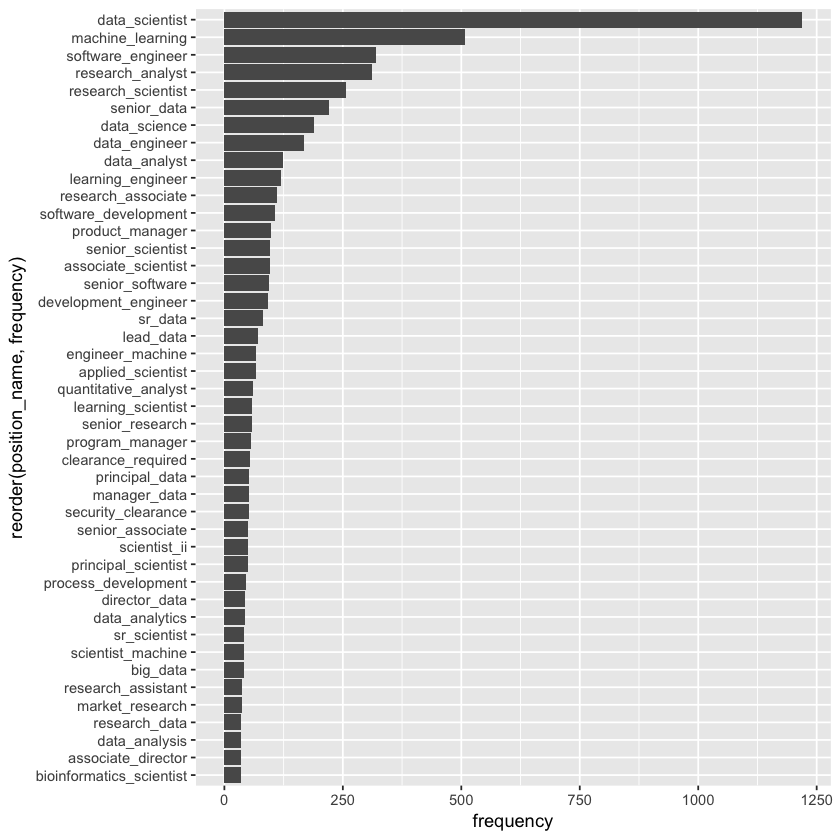

In [4]:
# preprocess job position column to remove numbers, punctuation, capital letters and stopwords
job_descriptions <- job_descriptions %>%
    mutate(position = tolower(position)) %>%
    mutate(position = removeNumbers(position)) %>%
    mutate(position = removePunctuation(position)) %>% 
    mutate(position = removeWords(position, stopwords("english")))

# create corpus from the position descriptions 
corpus_positions <- VCorpus(VectorSource(job_descriptions$position))

# create function that computes ngrams of 2 words
NLP_tokenizer <- function(x) {
  unlist(lapply(ngrams(words(x), 2), paste, collapse = "_"), use.names = FALSE)
}

# create term-document-matrix for positions and create dataframe with frequencies of bigrams
TDM_positions <- TermDocumentMatrix(corpus_positions, control = list(tokenize = NLP_tokenizer))
TDM_positions <- removeSparseTerms(TDM_positions, 0.995)
TDM_positions                          
                                    
# estracting aggregate information
frequency_of_position_names <- data.frame(frequency = row_sums(as.matrix(TDM_positions)))
frequency_of_position_names <- rownames_to_column(frequency_of_position_names, "position_name") %>%
    arrange(desc(frequency))

frequency_of_position_names %>%
    ggplot(aes(x = reorder(position_name, frequency), y = frequency)) +
    geom_col() + 
    coord_flip()

This crude analysis of bigram frequencies allows me to identify the bigrams associated to the  positions that interests me most (and possible common name variants):
1. "data science", " data scientis"
2. "software engineer", "software development", "development engineer"
3. "data engineer"
4. "data analyst", "quantitative analyst", "data analytics", "data analysis".
5. "machine learning engineer", "machine learning scientist", "engineer machine learning" (These trigrams have been inferred from bigrams that relate to them)


This allows me to give an approximate label to the job titles according to these braod categories. For the moment I will keep it simple and do that by matching strings with identifiers.

In [5]:
# define indentifiers
data_science_identifiers <- "\\bdata science\\b|\\bdata scientist\\b"
software_engineer_identifiers <- "\\bsoftware engineer\\b|\\bsoftware development\\b|\\bdevelopment engineer\\b"
data_engineer_identifiers <- "\\bdata engineer\\b"
data_analyst_identifiers <- "\\bdata analyst\\b|\\bquantitative analyst\\b|\\bdata analytics\\b|\\bdata analysis\\b"
machine_learning_engineer_identifiers <- "\\bmachine learning engineer\\b|\\bmachine learning scientist\\b|\\bengineer machine learning\\b"

# build list containing job labels with the associated identifiers
labels = c("data_science", "software_engineer", "data_engineer", "data_analyst", "machine_learning_engineer")
identifiers <- c(data_science_identifiers, software_engineer_identifiers, data_engineer_identifiers, data_analyst_identifiers, machine_learning_engineer_identifiers)
labeling_via_identifiers <- list(labels, identifiers)

# define function that combines together identifiers from different job labels
exclude_identifier <- function(labeling_conditions = labeling_via_identifiers, index_to_exclude = NULL){
    if(is.null(index_to_exclude))
        to_exclude <- paste(labeling_conditions[[2]][], collapse = "|")
    else
        to_exclude <- paste(labeling_conditions[[2]][-index_to_exclude], collapse = "|")
    return(to_exclude)
}

# define function that identify strings with at least one label from the ideintifiers
# of one job type and no identifiers from the other job types
find_position_with_unique_identifier_class <- function(position, index_of_interest, labeling_conditions = labeling_via_identifiers){
    possesses_desired_identifiers <- str_detect(job_descriptions$position, labeling_conditions[[2]][index_of_interest])
    possesses_undesired_identifiers <- str_detect(job_descriptions$position, exclude_identifier(labeling_conditions = labeling_via_identifiers, index_of_interest))
    return(possesses_desired_identifiers & (!possesses_undesired_identifiers))
}


# assign label to job_descriptions depending on the identifier found in the position column
job_descriptions <- job_descriptions %>%
    mutate(position_label_from_bigrams = case_when(
        find_position_with_unique_identifier_class(position, 1) == TRUE ~ "data_scientist",
        find_position_with_unique_identifier_class(position, 2) == TRUE ~ "software_engineer",
        find_position_with_unique_identifier_class(position, 3) == TRUE ~ "data_engineer",
        find_position_with_unique_identifier_class(position, 4) == TRUE ~ "data_analyst",
        find_position_with_unique_identifier_class(position, 5) == TRUE ~ "machine_learning_engineer",
        str_detect(position, exclude_identifier()) == FALSE ~ "other",
        TRUE ~ "mixed"
    ))

ERROR: Error in eval(expr, envir, enclos): object 'data_science_identifier' not found


Now that I have some starting 